In [4]:
# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import FISTA, HybridGLSQR
from cil.optimisation.utilities.HybridUpdateReg import UpdateRegDiscrep, UpdateRegGCV, UpdateRegLcurve, UpdateRegReginska, UpdateRegUPRE
from cil.optimisation.operators import GradientOperator
# Third-party imports
import numpy as np    

from cil.utilities.display import show2D

# Data information

In this notebook, we use the **Walnut** found in [Jørgensen_et_all](https://zenodo.org/record/4822516#.YLXyAJMzZp8). In total, there are 6 individual micro Computed Tomography datasets in the native Zeiss TXRM/TXM format. The six datasets were acquired at the 3D Imaging Center at Technical University of Denmark in 2014 (HDTomo3D in 2016) as part of the ERC-funded project High-Definition Tomography (HDTomo) headed by Prof. Per Christian Hansen. 

This example requires the dataset walnut.zip from https://zenodo.org/record/4822516 :

 - https://zenodo.org/record/4822516/files/walnut.zip

If running locally please download the data and update the `filename` variable below.

## Load walnut data

In [ ]:
from data_loader import load_and_process_walnut

# Unpack both return values, select every 25th angle
data, A, ig3D = load_and_process_walnut(angle_step=25)

# You can now immediately create your initial guess
initial = A.domain_geometry().allocate(0)

Loading data from: /mnt/share-private/materials/SIRF/Fully3D/CIL/Walnut/valnut_2014-03-21_643_28/tomo-A/valnut_tomo-A.txrm
Pre-processing with angle reduction step: 25...
New geometry:  3D Cone-beam tomography
System configuration:
	Source position: [   0.        , -105.05081177,    0.        ]
	Rotation axis position: [0., 0., 0.]
	Rotation axis direction: [0., 0., 1.]
	Detector position: [ 0.        , 45.08757401,  0.        ]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [1024 1024]
	Pixel size: [0.0658543 0.0658543]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 65
	Angles 0-9 in radians: [-3.1415665, -3.0434484, -2.945264 , -2.847109 , -2.7489111, -2.6507533,
 -2.5525775, -2.454381 , -2.3561862, -2.257994 ]
	Angles 55-64 in radians: [2.2580016, 2.356183 , 2.4543426, 2.5525136, 2.6507554, 2.748842 ,
 2.8470535, 2.9452505, 3.0433784, 3.1415997]
	

## Hybrid methods in action L1 Regularization

1. Discrepency
2. GCV
3. Weighted GCV
4. Adaptive Weighted GCV
5. Reginska
6. UPRE
7. L-curve


In [6]:
# We set a tolerance, an initial guess, and a maximum number of iterations
alpha_tol = 1e-2
maxit = 30

# Define noise level
noise_std = 0.5 * np.std(data.array) 
noiselevel = 0.2 *  data.norm()
noisevariance = noise_std**2

# Norm Type
norm_type = 'L2'

# Flag to reinitialize GKB at each outer iteration
reinitialize_GKB = True

# 3D Gradient operator
G = GradientOperator(
    ig3D,
    method='forward',            # required for C backend
    bnd_cond='Neumann',           # or 'Periodic'
    correlation='Space',          # gradient only in spatial dimensions
    backend='c'                   # will fall back to numpy if needed
)

## 1. Discrepency Rule

In [7]:
discrep_rule = UpdateRegDiscrep(data_size=data.size,
                                domain_size=initial.size, 
                                tol=1e-3,
                                noise_level_estimate=noiselevel)

hybridlsqrD = HybridGLSQR(operator=A, data=data, initial=initial,
                          struct_operator=G,
                         reg_norm_type=norm_type, hybrid_reg_rule=discrep_rule)
hybridlsqrD.run(maxit, verbose=True)


/home/dnz75396/CIL/Wrappers/Python/cil/framework/data_container.py:112: UserWarning: Over-riding geometry.dtype with data.dtype
  warnings.warn("Over-riding geometry.dtype with data.dtype", UserWarning)


  0%|          | 0/30 [00:00<?, ?it/s]

The optimal parameter it finds is 0.0 in 30 iterations


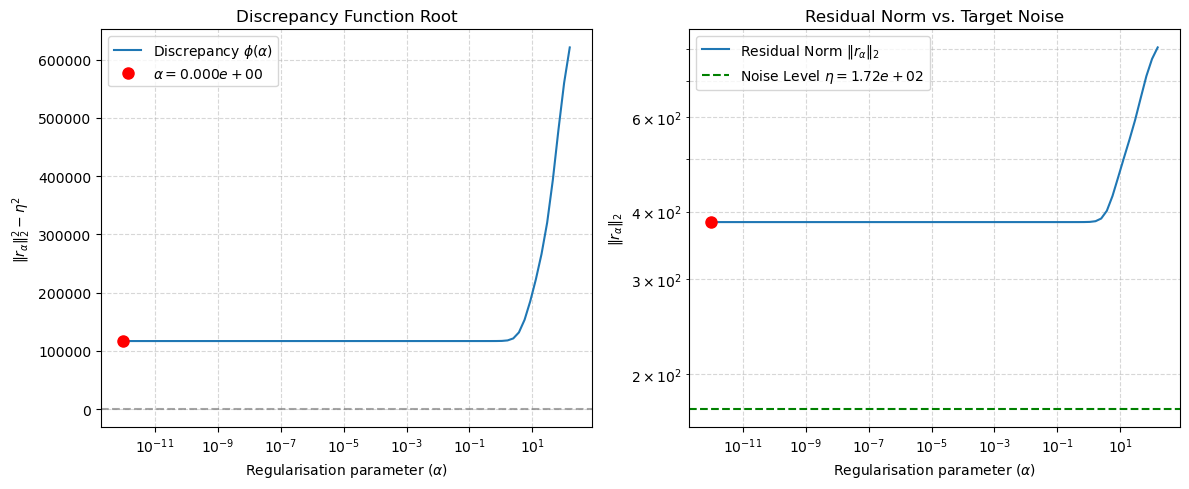

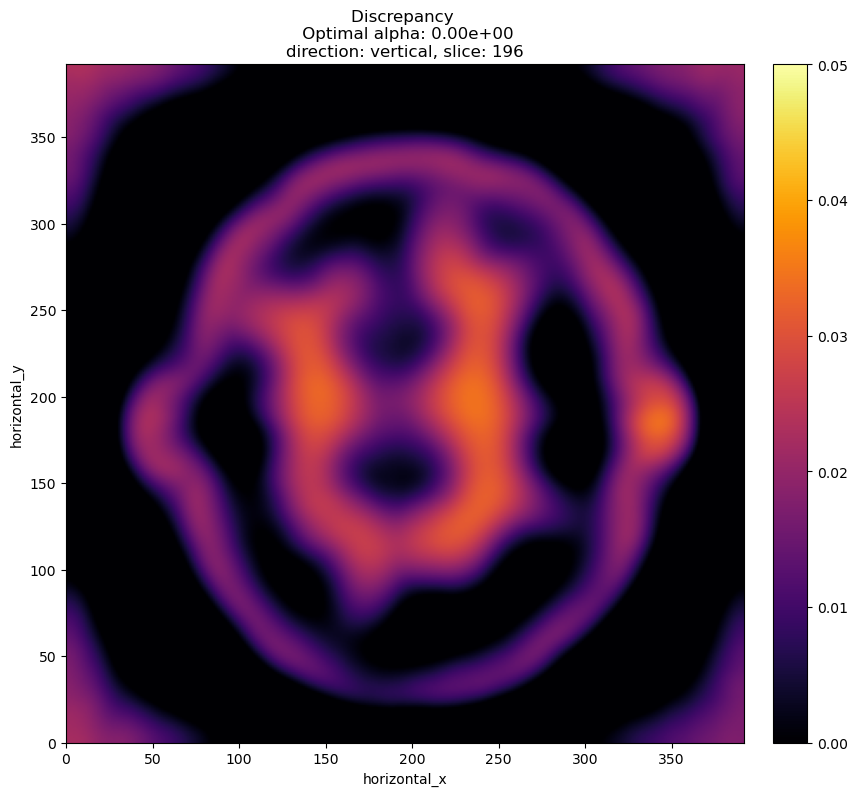

In [8]:
print("The optimal parameter it finds is", hybridlsqrD.regalpha, "in", hybridlsqrD.iteration, "iterations")

hybridlsqrD.reg_rule.plot_function()
try:  
    hybridlsqrD.reg_rule.plot_history()
except:
    pass

show2D(hybridlsqrD.solution,
        title=f"Discrepancy \n Optimal alpha: {hybridlsqrD.regalpha:.2e}",
        slice_list={'vertical':200}, 
        cmap="inferno",
         fix_range=(0, 0.05))

## 2. Standard GCV Rule

In [9]:
gcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                adaptive_weight=False)

hybridlsqrgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                           struct_operator=G,
                         reg_norm_type=norm_type, hybrid_reg_rule=gcv_rule)
hybridlsqrgcv.run(maxit, verbose=True)

KeyboardInterrupt: 

The optimal parameter it finds is 152.93947026544657 in 4 iterations


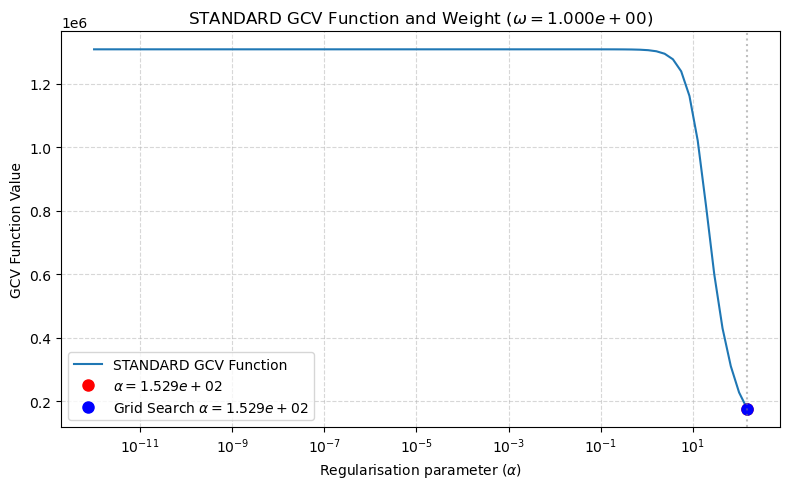

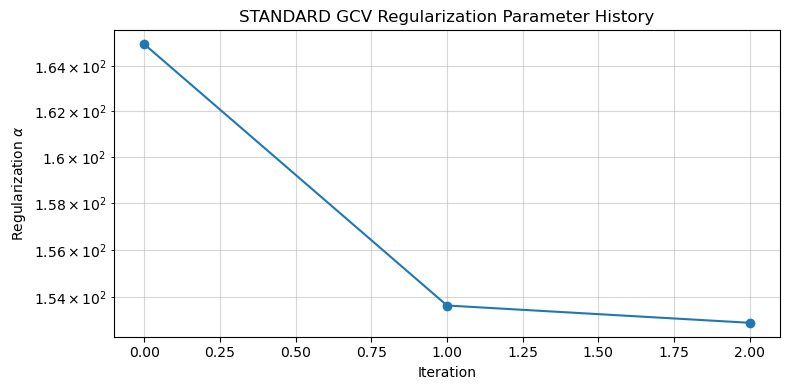

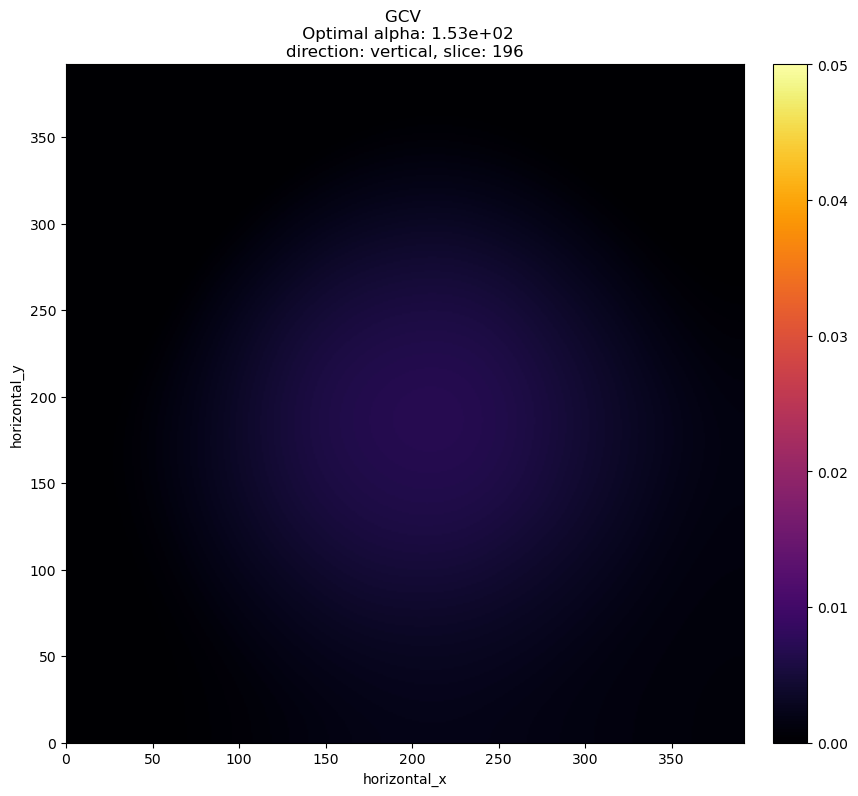

In [ ]:
print("The optimal parameter it finds is", hybridlsqrgcv.regalpha, "in", hybridlsqrgcv.iteration, "iterations")

hybridlsqrgcv.reg_rule.plot_function()
hybridlsqrgcv.reg_rule.plot_history()

show2D(hybridlsqrgcv.solution,
        title=f"GCV \n Optimal alpha: {hybridlsqrgcv.regalpha:.2e}",
        slice_list={'vertical':200}, 
        cmap="inferno",
         fix_range=(0, 0.05))

## 3. Weighted GCV Rule

In [ ]:
wgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=False)

hybridlsqrwgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            struct_operator=G,
                            reg_norm_type=norm_type, hybrid_reg_rule=wgcv_rule)
hybridlsqrwgcv.run(maxit, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

The optimal parameter it finds is 152.93947026544657 in 4 iterations


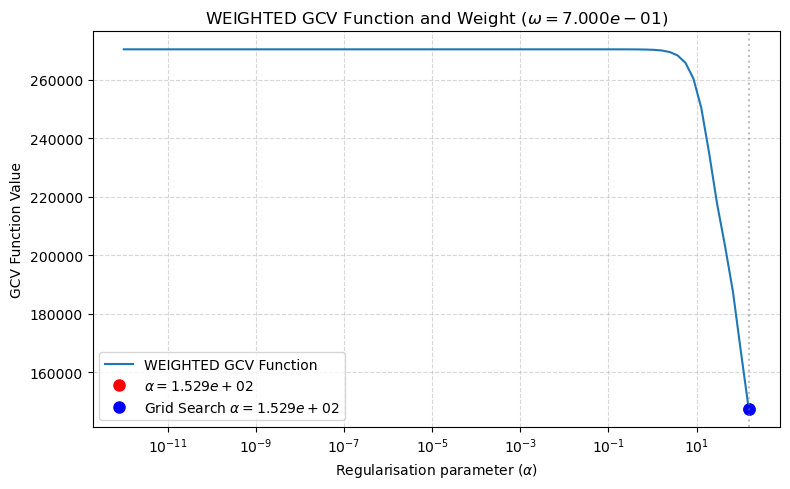

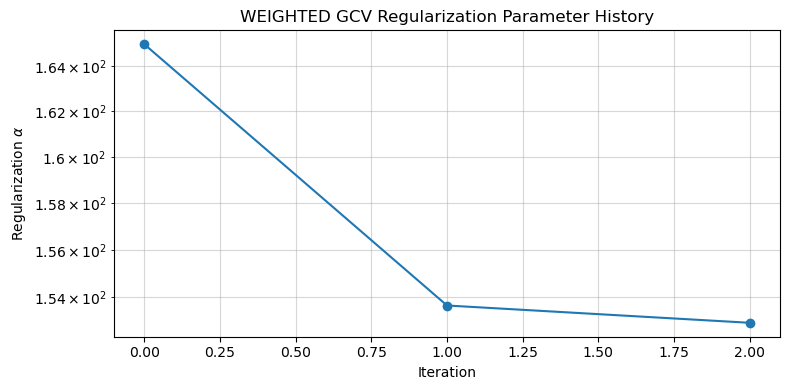

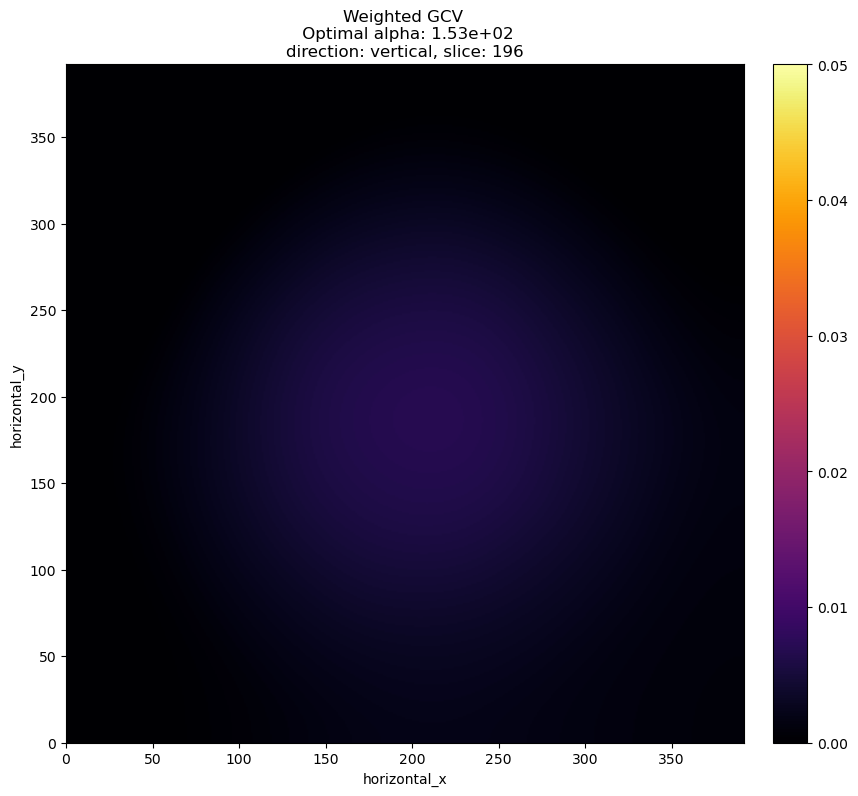

In [ ]:
print("The optimal parameter it finds is", hybridlsqrwgcv.regalpha, "in", hybridlsqrwgcv.iteration, "iterations")

hybridlsqrwgcv.reg_rule.plot_function()
hybridlsqrwgcv.reg_rule.plot_history()

show2D(hybridlsqrwgcv.solution,
        title=f"Weighted GCV \n Optimal alpha: {hybridlsqrwgcv.regalpha:.2e}",
        slice_list={'vertical':200}, 
        cmap="inferno",
         fix_range=(0, 0.05))

## 4. Adaptive-Weighted GCV Rule

In [ ]:
awgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=True)

hybridlsqrawgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                              struct_operator=G,
                         reg_norm_type=norm_type, hybrid_reg_rule=awgcv_rule)
hybridlsqrawgcv.run(maxit, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

The optimal parameter it finds is 152.93947026544657 in 4 iterations


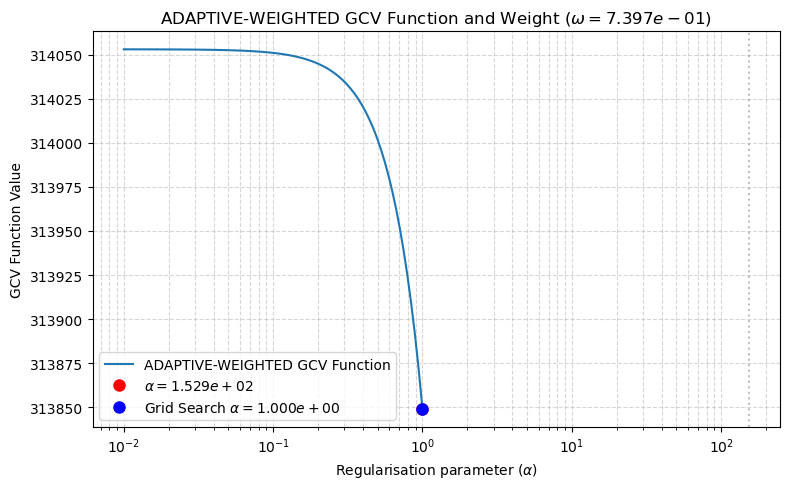

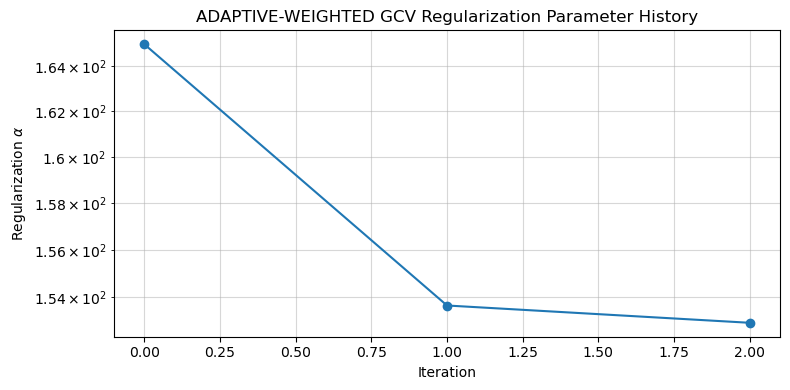

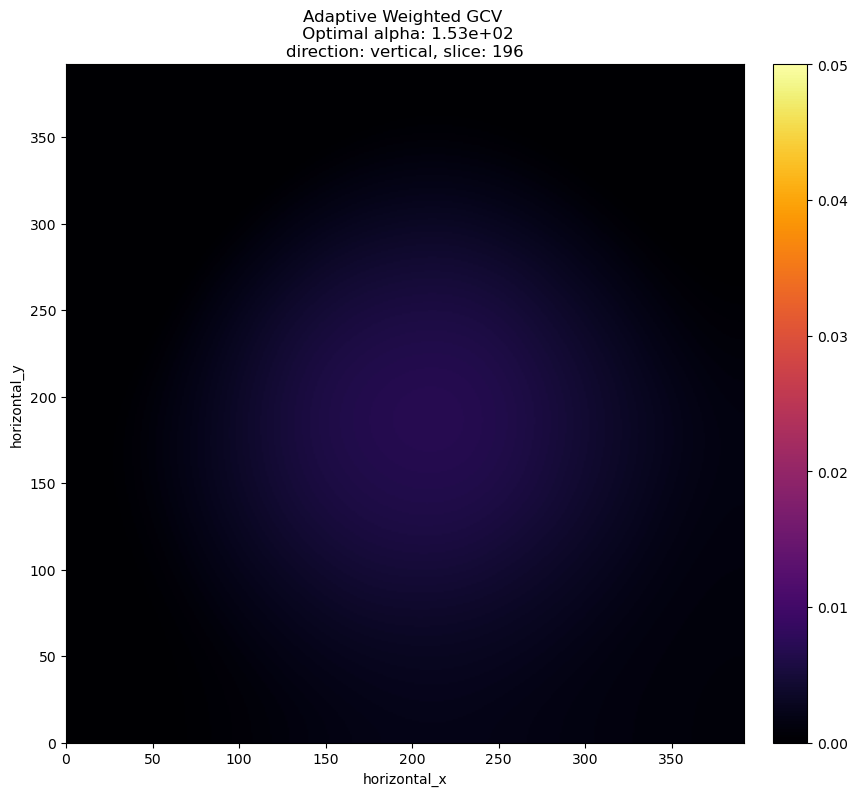

In [ ]:
print("The optimal parameter it finds is", hybridlsqrawgcv.regalpha, "in", hybridlsqrawgcv.iteration, "iterations")

hybridlsqrawgcv.reg_rule.plot_function(regalpha_limits=(1e-2, 1))
hybridlsqrawgcv.reg_rule.plot_history()

show2D(hybridlsqrawgcv.solution,
        title=f"Adaptive Weighted GCV \n Optimal alpha: {hybridlsqrawgcv.regalpha:.2e}",
        slice_list={'vertical':200}, 
        cmap="inferno",
         fix_range=(0, 0.05))

## 5. Reginska Rule

In [ ]:
reginska_rule = UpdateRegReginska(data_size=data.size,
                                domain_size=initial.size, 
                                tol=1e-3,
                                mu=0.5)

hybridlsqrreginska = HybridGLSQR(operator=A, data=data, initial=initial,
                                 struct_operator=G,
                         reg_norm_type=norm_type, hybrid_reg_rule=reginska_rule)
hybridlsqrreginska.run(maxit, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

The optimal parameter it finds is 152.92996128344674 in 5 iterations


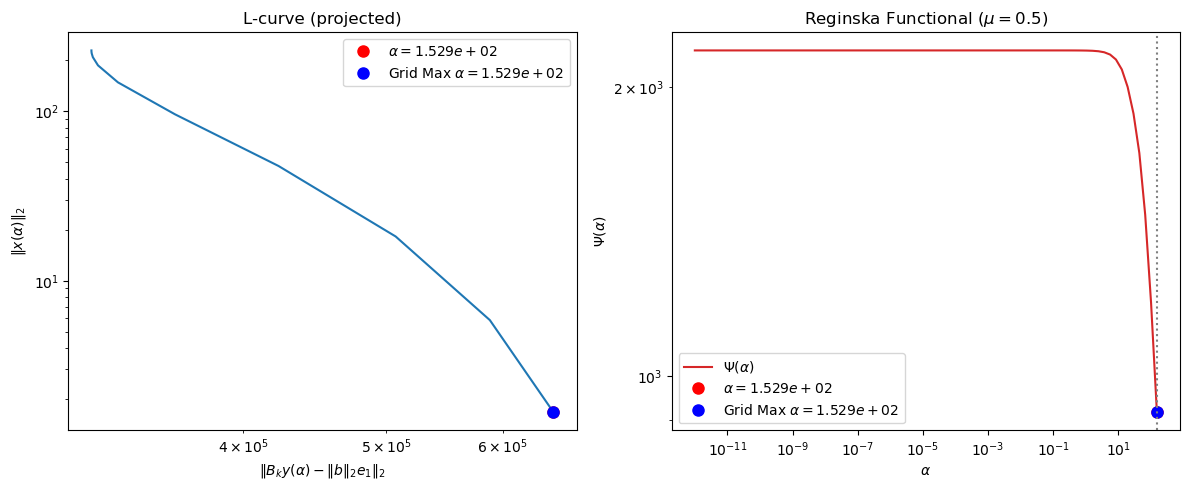

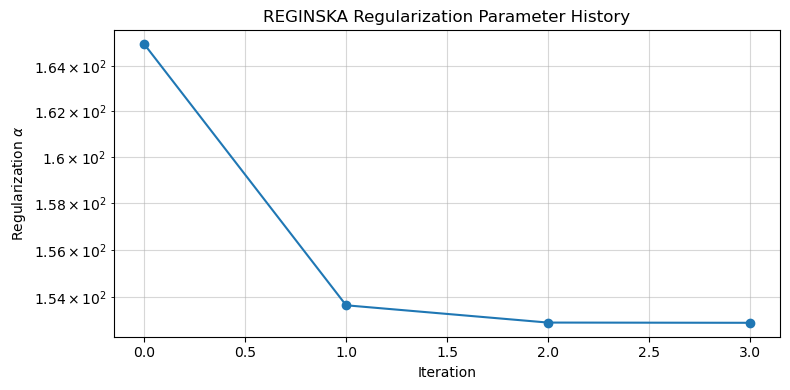

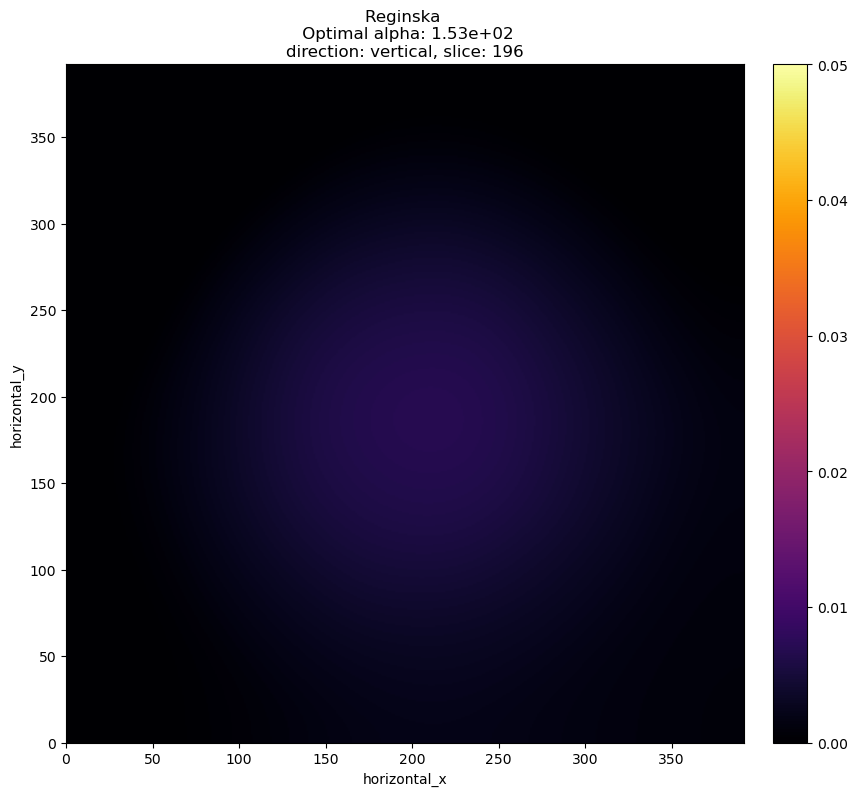

In [ ]:
print("The optimal parameter it finds is", hybridlsqrreginska.regalpha, "in", hybridlsqrreginska.iteration, "iterations")

hybridlsqrreginska.reg_rule.plot_function()
hybridlsqrreginska.reg_rule.plot_history()

show2D(hybridlsqrreginska.solution,
        title=f"Reginska \n Optimal alpha: {hybridlsqrreginska.regalpha:.2e}",
        slice_list={'vertical':200}, 
        cmap="inferno",
         fix_range=(0, 0.05))

## 5. UPRE Rule

In [ ]:
upre_rule = UpdateRegUPRE(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                noise_variance=noisevariance)

hybridlsqrupre = HybridGLSQR(operator=A, data=data, initial=initial,
                             struct_operator=G,
                         reg_norm_type=norm_type, hybrid_reg_rule=upre_rule)
hybridlsqrupre.run(maxit, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

The optimal parameter it finds is 0.011346170975471333 in 4 iterations


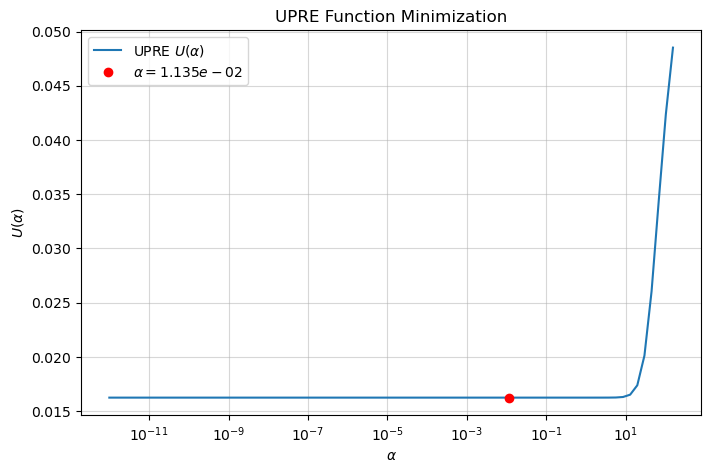

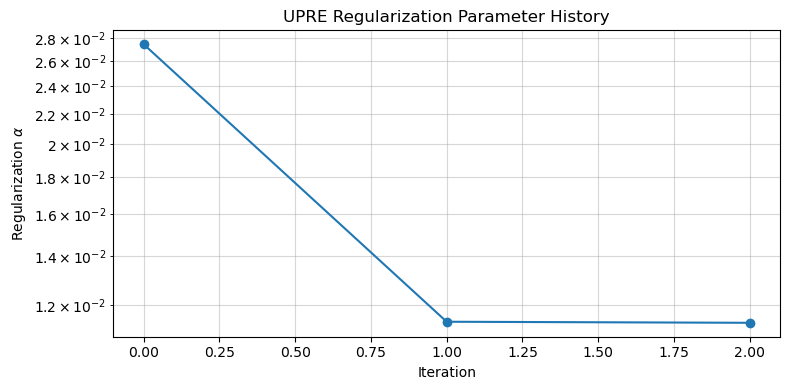

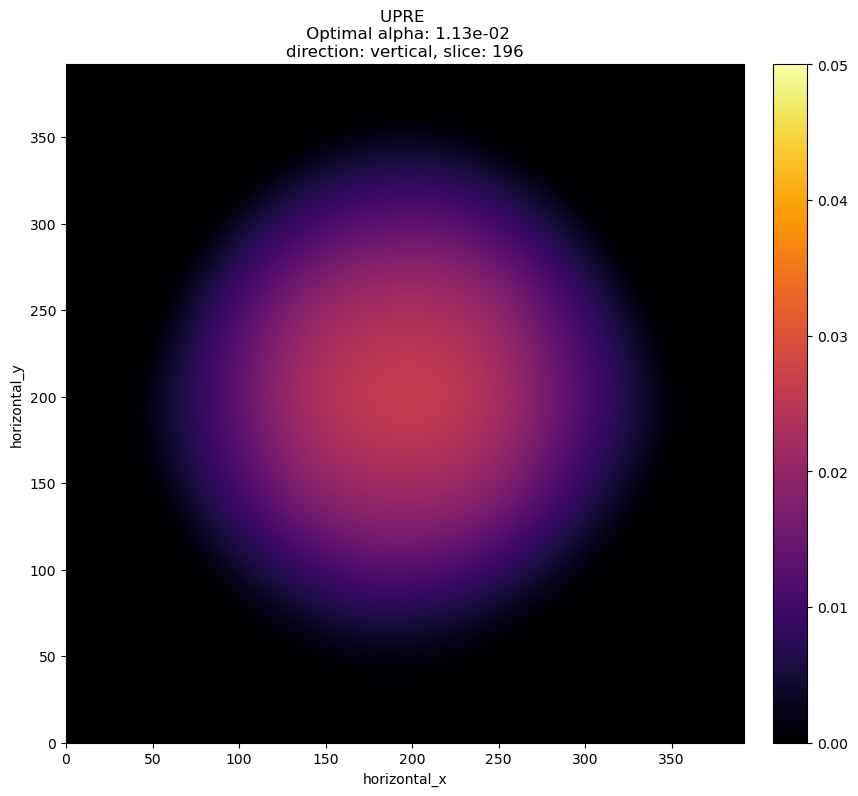

In [ ]:
print("The optimal parameter it finds is", hybridlsqrupre.regalpha, "in", hybridlsqrupre.iteration, "iterations")

hybridlsqrupre.reg_rule.plot_function()
try:
    hybridlsqrupre.reg_rule.plot_history()
except:
    pass

show2D(hybridlsqrupre.solution,
        title=f"UPRE \n Optimal alpha: {hybridlsqrupre.regalpha:.2e}",
        slice_list={'vertical':200}, 
        cmap="inferno",
         fix_range=(0, 0.05))

## 7. L-curve Rule

In [ ]:
lcurve_rule = UpdateRegLcurve(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol)

hybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,
                           struct_operator=G,
                         reg_norm_type=norm_type, hybrid_reg_rule=lcurve_rule)
hybridlsqrlcurve.run(maxit, verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

The optimal parameter it finds is 3.5483046157060006e-06 in 10 iterations


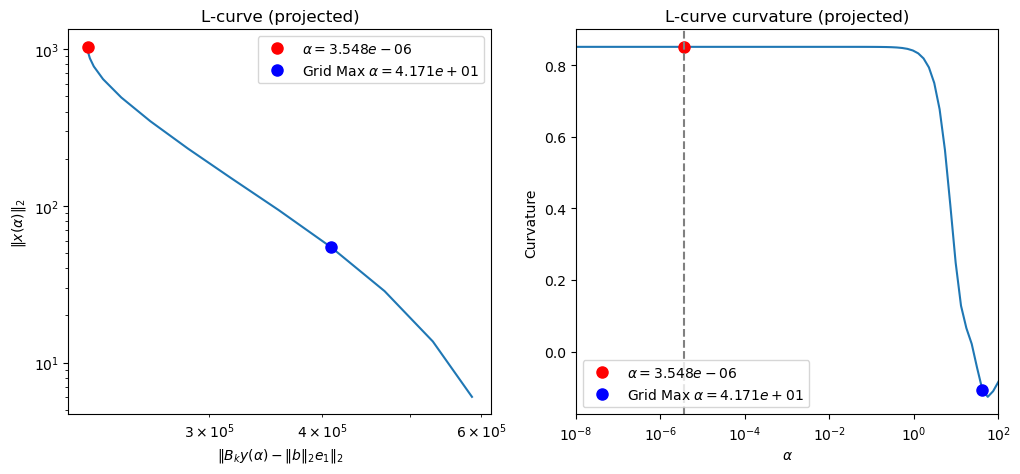

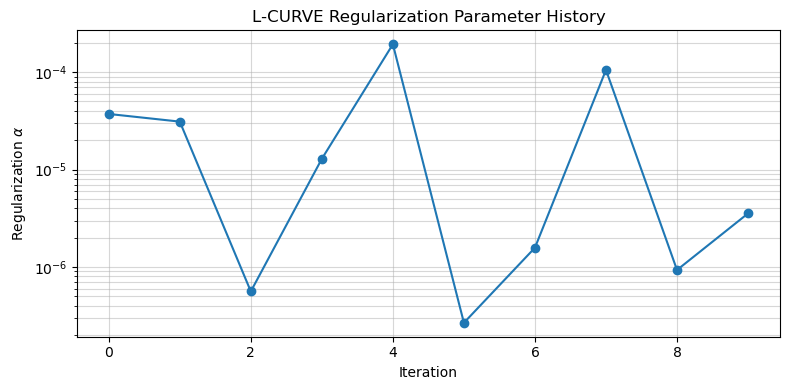

In [ ]:
print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")

hybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-8, 1e2))
hybridlsqrlcurve.reg_rule.plot_history()

## Display Results
The results are shown in the figure below. 

In [ ]:
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
# Define the list of solutions and titles once
solutions = [hybridlsqrD.solution, hybridlsqrgcv.solution, hybridlsqrwgcv.solution, hybridlsqrawgcv.solution,
             hybridlsqrlcurve.solution, hybridlsqrreginska.solution, hybridlsqrupre.solution]

titles = [
    f'Discrep alpha = {hybridlsqrD.regalpha:.2e}',
    f'GCV alpha = {hybridlsqrgcv.regalpha:.2e}', 
    f'WGCV alpha = {hybridlsqrwgcv.regalpha:.2e}', 
    f'AWGCV alpha = {hybridlsqrawgcv.regalpha:.2e}',
    f'LCURVE alpha = {hybridlsqrlcurve.regalpha:.2e}',
    f'REGINSKA alpha = {hybridlsqrreginska.regalpha:.2e}',
    f'UPRE alpha = {hybridlsqrupre.regalpha:.2e}'
]

# Mapping for the dropdown
rule_options = {
    'All Rules': None,
    'Discrepancy': 0,
    'GCV': 1,
    'WGCV': 2,
    'AWGCV': 3,
    'L-Curve': 4,
    'Reginska': 5,
    'UPRE': 6
}

def update_display(vslice, rule_name,norm_name='L2'):
    # Determine which solutions to show
    idx = rule_options[rule_name]
    
    if idx is None:
        # Show all
        current_solutions = solutions
        current_titles = titles
        cols = 4
    else:
        # Show only the selected one
        current_solutions = [solutions[idx]]
        current_titles = [titles[idx]]
        cols = 1

    # Render using show2D
    fig = show2D(
        current_solutions,
        cmap='inferno', 
        fix_range=(0, 0.05), 
        slice_list=('vertical', vslice), 
        num_cols=cols,
        title=current_titles
    )
    
    # Add the overall title (suptitle)
    # We use plt.gcf() to ensure we grab the figure show2D just created
    fig = plt.gcf()
    fig.suptitle(f"Hybrid GLSQR Analysis {norm_name}\nRule: {rule_name} | Vertical Slice: {vslice}", 
                 fontsize=14, fontweight='bold', y=1.05)
    
    # Adjust layout so the suptitle doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Determine dimensions
max_vslice = solutions[0].shape[0] - 1

# Create the interactive dashboard
interact(
    update_display, 
    vslice=IntSlider(min=0, max=max_vslice, step=1, value=200, description='Slice:'),
    rule_name=Dropdown(options=list(rule_options.keys()), value='Reginska', description='Rule:')
);

interactive(children=(IntSlider(value=200, description='Slice:', max=391), Dropdown(description='Rule:', index…